In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, chisquare
import bettools

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.options.mode.chained_assignment = None

season_list = bettools.generate_seasons(2020, 2024)

league_list = ["E0", "E1", "E2", "E3"]

main_df = pd.concat(bettools.get_data(season_list, league_list))

main_df

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,PSH,PSD,PSA,home_max_odds,away_max_odds
0,E0,2020-09-12,Fulham,Arsenal,0,3,6.16,4.51,1.56,6.50,1.57
1,E0,2020-09-12,Crystal Palace,Southampton,1,0,3.32,3.29,2.40,3.32,2.45
2,E0,2020-09-12,Liverpool,Leeds,4,3,1.31,6.25,9.92,1.35,10.50
3,E0,2020-09-12,West Ham,Newcastle,0,2,2.18,3.61,3.50,2.18,3.60
4,E0,2020-09-13,West Brom,Leicester,0,3,4.00,3.59,2.00,4.00,2.00
...,...,...,...,...,...,...,...,...,...,...,...
449,E3,2024-03-16,Gillingham,Grimsby,1,1,2.07,3.42,3.88,2.07,4.00
450,E3,2024-03-16,Milton Keynes Dons,Crewe,3,1,1.95,3.74,3.90,1.95,4.00
451,E3,2024-03-16,Swindon,Doncaster,1,2,2.23,3.81,3.10,2.23,3.20
452,E3,2024-03-16,Wrexham,Tranmere,0,1,1.54,4.52,5.92,1.54,6.00


In [97]:
main_df = main_df[["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG"]]
main_df["TotalGoals"] = main_df["FTHG"] + main_df["FTAG"]

In [98]:
mean_goals = main_df["TotalGoals"].mean()
max_goals = main_df["TotalGoals"].max()
goal_range = np.arange(0, max_goals + 1)

poisson_probabilities = poisson.pmf(goal_range, mean_goals)

In [99]:
mean_goals

2.5963917525773197

In [100]:
max_goals

11

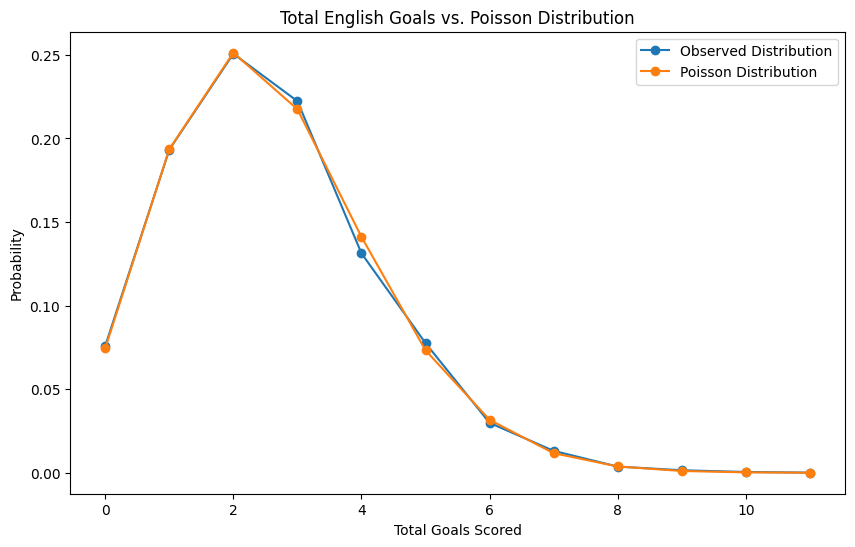

In [101]:
observed_frequencies = main_df["TotalGoals"].value_counts().sort_index()
observed_probabilities = observed_frequencies / observed_frequencies.sum()

observed_probabilities = observed_probabilities.reindex(goal_range, fill_value=0)

plt.figure(figsize=(10, 6))
plt.plot(
    observed_probabilities.index,
    observed_probabilities,
    "o-",
    label="Observed Distribution",
)
plt.plot(goal_range, poisson_probabilities, "o-", label="Poisson Distribution")
plt.xlabel("Total Goals Scored")
plt.ylabel("Probability")
plt.title("Total English Goals vs. Poisson Distribution")
plt.legend()
plt.show()

In [102]:
## are there some scorelines which are overrepresented in the dataset?

mean_home_goals = main_df["FTHG"].mean()
mean_away_goals = main_df["FTAG"].mean()


def expected_scoreline_probability(
    home_goals, away_goals, mean_home_goals, mean_away_goals
):
    prob_home_goals = poisson.pmf(home_goals, mean_home_goals)
    prob_away_goals = poisson.pmf(away_goals, mean_away_goals)
    return prob_home_goals * prob_away_goals


total_matches = len(main_df)

# Calculate observed frequencies for each scoreline
observed_frequencies = main_df.groupby(["FTHG", "FTAG"]).size()

# Calculate expected frequencies for each observed scoreline
expected_frequencies = {}
for scoreline, count in observed_frequencies.items():
    home_goals, away_goals = scoreline
    expected_prob = expected_scoreline_probability(
        home_goals, away_goals, mean_home_goals, mean_away_goals
    )
    expected_frequencies[scoreline] = expected_prob * total_matches

# Compare observed vs. expected
for scoreline in sorted(observed_frequencies.keys()):
    observed = observed_frequencies[scoreline]
    expected = expected_frequencies[scoreline]
    print(
        f"Scoreline {scoreline}: Observed = {observed}, Expected = {expected:.2f}, Difference = {observed - expected:.2f}"
    )

Scoreline (0, 0): Observed = 589, Expected = 578.45, Difference = 10.55
Scoreline (0, 1): Observed = 676, Expected = 684.15, Difference = -8.15
Scoreline (0, 2): Observed = 426, Expected = 404.58, Difference = 21.42
Scoreline (0, 3): Observed = 174, Expected = 159.50, Difference = 14.50
Scoreline (0, 4): Observed = 67, Expected = 47.16, Difference = 19.84
Scoreline (0, 5): Observed = 23, Expected = 11.16, Difference = 11.84
Scoreline (0, 6): Observed = 5, Expected = 2.20, Difference = 2.80
Scoreline (0, 7): Observed = 3, Expected = 0.37, Difference = 2.63
Scoreline (0, 8): Observed = 1, Expected = 0.05, Difference = 0.95
Scoreline (1, 0): Observed = 824, Expected = 817.73, Difference = 6.27
Scoreline (1, 1): Observed = 928, Expected = 967.15, Difference = -39.15
Scoreline (1, 2): Observed = 566, Expected = 571.94, Difference = -5.94
Scoreline (1, 3): Observed = 216, Expected = 225.48, Difference = -9.48
Scoreline (1, 4): Observed = 82, Expected = 66.67, Difference = 15.33
Scoreline (1,

In [107]:
# this left here for the video - the chi squared test does not work as the results do not fit into a poisson

# scorelines_over_250 = observed_frequencies[observed_frequencies > 250]

# selected_expected_frequencies = {scoreline: expected_frequencies[scoreline] for scoreline in scorelines_over_250.index}

# # Perform Chi-squared test
# chi_squared_stats = {}
# for scoreline in scorelines_over_250.index:
#     observed = scorelines_over_250[scoreline]
#     expected = selected_expected_frequencies[scoreline]
#     chi_stat, p_value = chisquare(f_obs=[observed], f_exp=[expected])
#     chi_squared_stats[scoreline] = (chi_stat, p_value)

# # Print results
# for scoreline, stats in chi_squared_stats.items():
#     chi_stat, p_value = stats
#     print(f"Scoreline {scoreline}: Chi-squared Stat = {chi_stat:.2f}, p-value = {p_value:.4f}")

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
0.018244761631702473

In [114]:
from scipy.stats import norm

# Filtering observed scorelines with more than 250 instances
scorelines_over_250 = {
    scoreline: observed
    for scoreline, observed in observed_frequencies.items()
    if observed > 250
}

# Initialize a dictionary to store the Z-scores, p-values, observed, and expected counts
z_scores_p_values_obs_exp = {}

# Calculate Z-scores and p-values for each filtered scoreline, including observed and expected counts
for scoreline, observed in scorelines_over_250.items():
    expected = expected_frequencies[scoreline]
    if expected > 0:  # Ensure there's an expected frequency to compare against
        # Calculate proportions
        p_obs = observed / total_matches
        p_exp = expected / total_matches

        # Calculate standard error for the expected proportion
        standard_error = (p_exp * (1 - p_exp) / total_matches) ** 0.5

        # Calculate the Z-score
        Z = (p_obs - p_exp) / standard_error

        # Calculate the p-value from the Z-score (two-tailed test)
        p_value = 2 * norm.sf(abs(Z))

        # Store the results including observed and expected counts
        z_scores_p_values_obs_exp[scoreline] = (Z, p_value, observed, expected)

# Print the results including observed and expected counts
for scoreline, (Z, p_value, observed, expected) in z_scores_p_values_obs_exp.items():
    print(
        f"Scoreline {scoreline}: Observed = {observed}, Expected = {expected:.2f}, Z-score = {Z:.3f}, p-value = {p_value:.4f}"
    )

Scoreline (0, 0): Observed = 589, Expected = 578.45, Z-score = 0.456, p-value = 0.6483
Scoreline (0, 1): Observed = 676, Expected = 684.15, Z-score = -0.326, p-value = 0.7443
Scoreline (0, 2): Observed = 426, Expected = 404.58, Z-score = 1.094, p-value = 0.2741
Scoreline (1, 0): Observed = 824, Expected = 817.73, Z-score = 0.232, p-value = 0.8166
Scoreline (1, 1): Observed = 928, Expected = 967.15, Z-score = -1.346, p-value = 0.1784
Scoreline (1, 2): Observed = 566, Expected = 571.94, Z-score = -0.258, p-value = 0.7963
Scoreline (2, 0): Observed = 591, Expected = 577.99, Z-score = 0.562, p-value = 0.5739
Scoreline (2, 1): Observed = 698, Expected = 683.61, Z-score = 0.576, p-value = 0.5644
Scoreline (2, 2): Observed = 345, Expected = 404.26, Z-score = -3.027, p-value = 0.0025
Scoreline (3, 0): Observed = 287, Expected = 272.36, Z-score = 0.903, p-value = 0.3666
Scoreline (3, 1): Observed = 281, Expected = 322.13, Z-score = -2.341, p-value = 0.0192
